# scVI

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).
- **Affiliation:** Helmholtz Munich, Institute of Computational Biology (ICB), Talavera-López Lab
- **Date of Creation:** 05.01.2023
- **Date of Last Modification:** 13.01.2023

- The scVI source code is available at https://github.com/scverse/scvi-tools.
- The corresponding publication is "Lopez, R., Regier, J., Cole, M. B., Jordan, M. I. & Yosef, N. Deep generative modeling for single-cell transcriptomics. Nat. Methods 15, 1053–1058 (2018)".

- The workflow of this notebook follows the tutorial from https://docs.scvi-tools.org/en/stable/tutorials/notebooks/api_overview.html.
- The authors use raw counts as input to scVI. Therefore, we also use raw counts (stored in adata.X).

## 1. Setup

### 1.1 Import Libraries

In [2]:
from datetime import datetime

import scvi
import scanpy as sc
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'scvi'

### 1.2 Define Parameters

In [2]:
dataset = "seqfish_mouse_organogenesis_embryo2"
cell_type_key = "celltype_mapped_refined"
latent_key = "scvi_latent"
leiden_resolution = 0.5 # used for Leiden clustering of latent space
random_seed = 0

### 1.3 Run Notebook Setup

In [3]:
sc.set_figure_params(figsize=(6, 6))

In [4]:
# Get time of notebook execution for timestamping saved artifacts
now = datetime.now()
current_timestamp = now.strftime("%d%m%Y_%H%M%S")

### 1.4 Configure Paths and Directories

In [5]:
data_folder_path = "../../datasets/srt_data/gold/"
figure_folder_path = f"../../figures/method_benchmarking/{dataset}/scvi"

In [ ]:
# Create required directories
os.makedirs(figure_folder_path, exist_ok=True)

## 2. Data

In [6]:
# Load Data
adata_original = sc.read_h5ad(data_folder_path + f"{dataset}.h5ad")

## 3. Raw Gene Expression PCA

/home/cartalop/anaconda3/envs/scvi/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


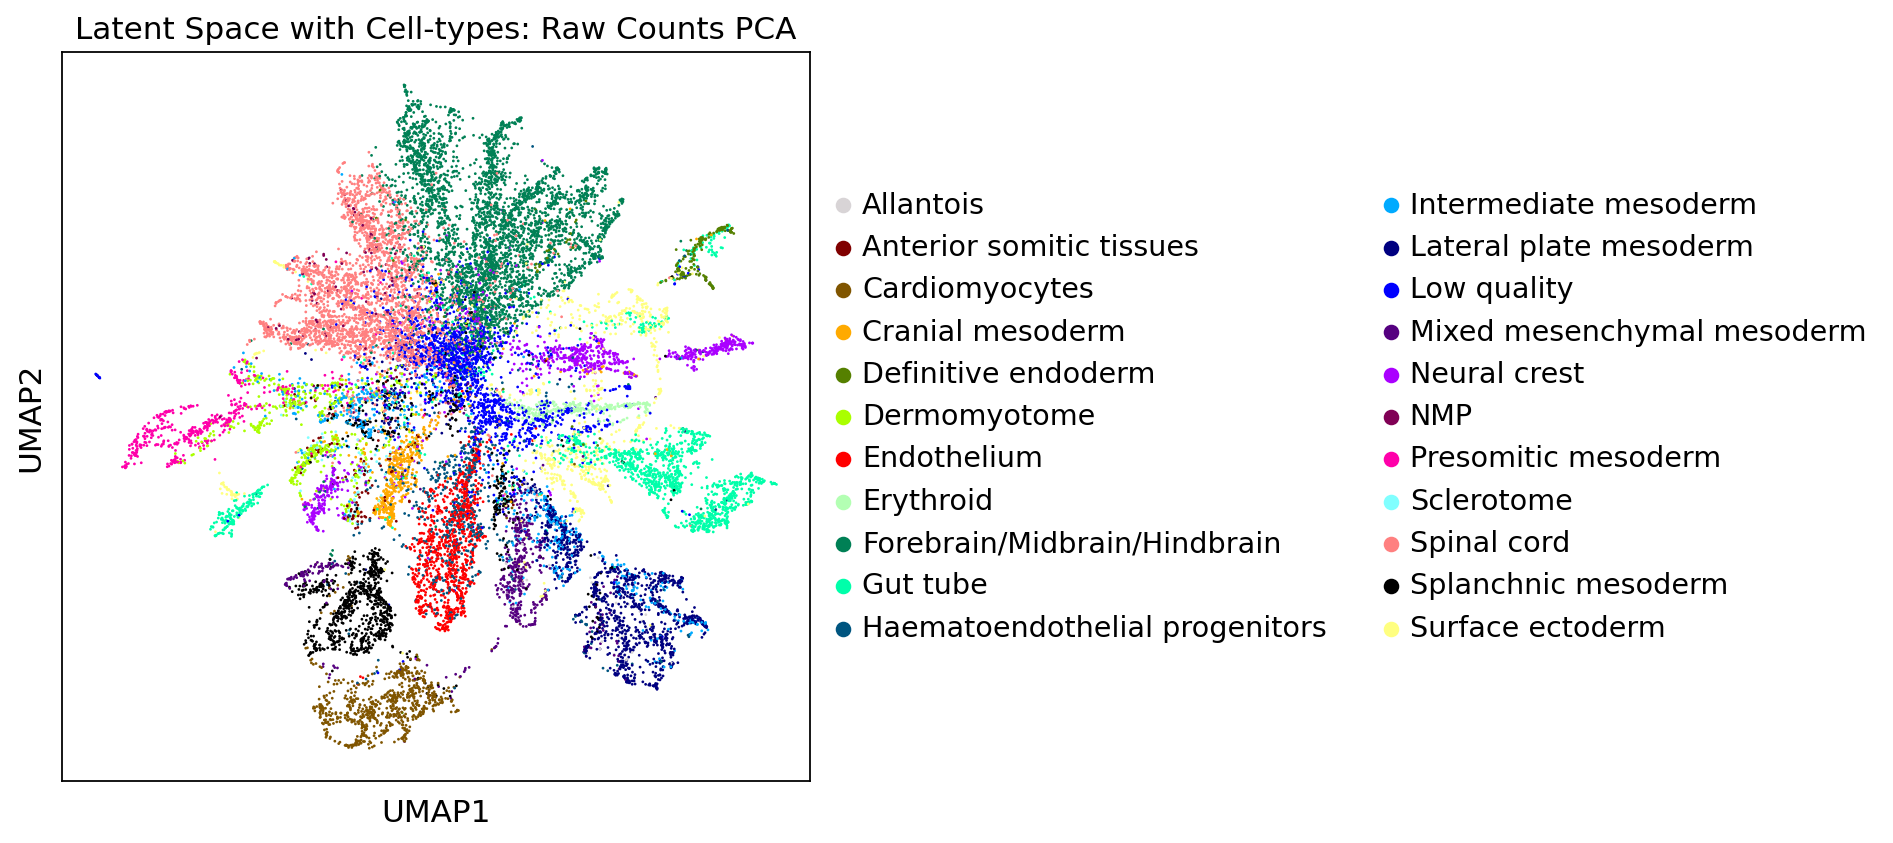

In [7]:
# Run PCA on log-normalized counts, then generate UMAP plot with cell-type annotations
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=50, n_neighbors=n_neighbors)
sc.tl.umap(adata, min_dist=0.3)

fig = sc.pl.umap(adata,
                 color=[cell_type_key],
                 title="Latent Space with Cell-types: Raw Counts PCA",
                 return_fig=True)
fig.savefig(f"{figure_folder_path}/latent_raw_counts_pca_cell_types_{current_timestamp}.png",
            bbox_inches="tight")

In [8]:
# Compute latent Leiden clustering
sc.tl.leiden(adata=adata,
             resolution=leiden_resolution,
             random_state=random_seed,
             key_added=f"latent_raw_counts_pca_leiden_{str(leiden_resolution)}")

/home/cartalop/anaconda3/envs/scvi/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


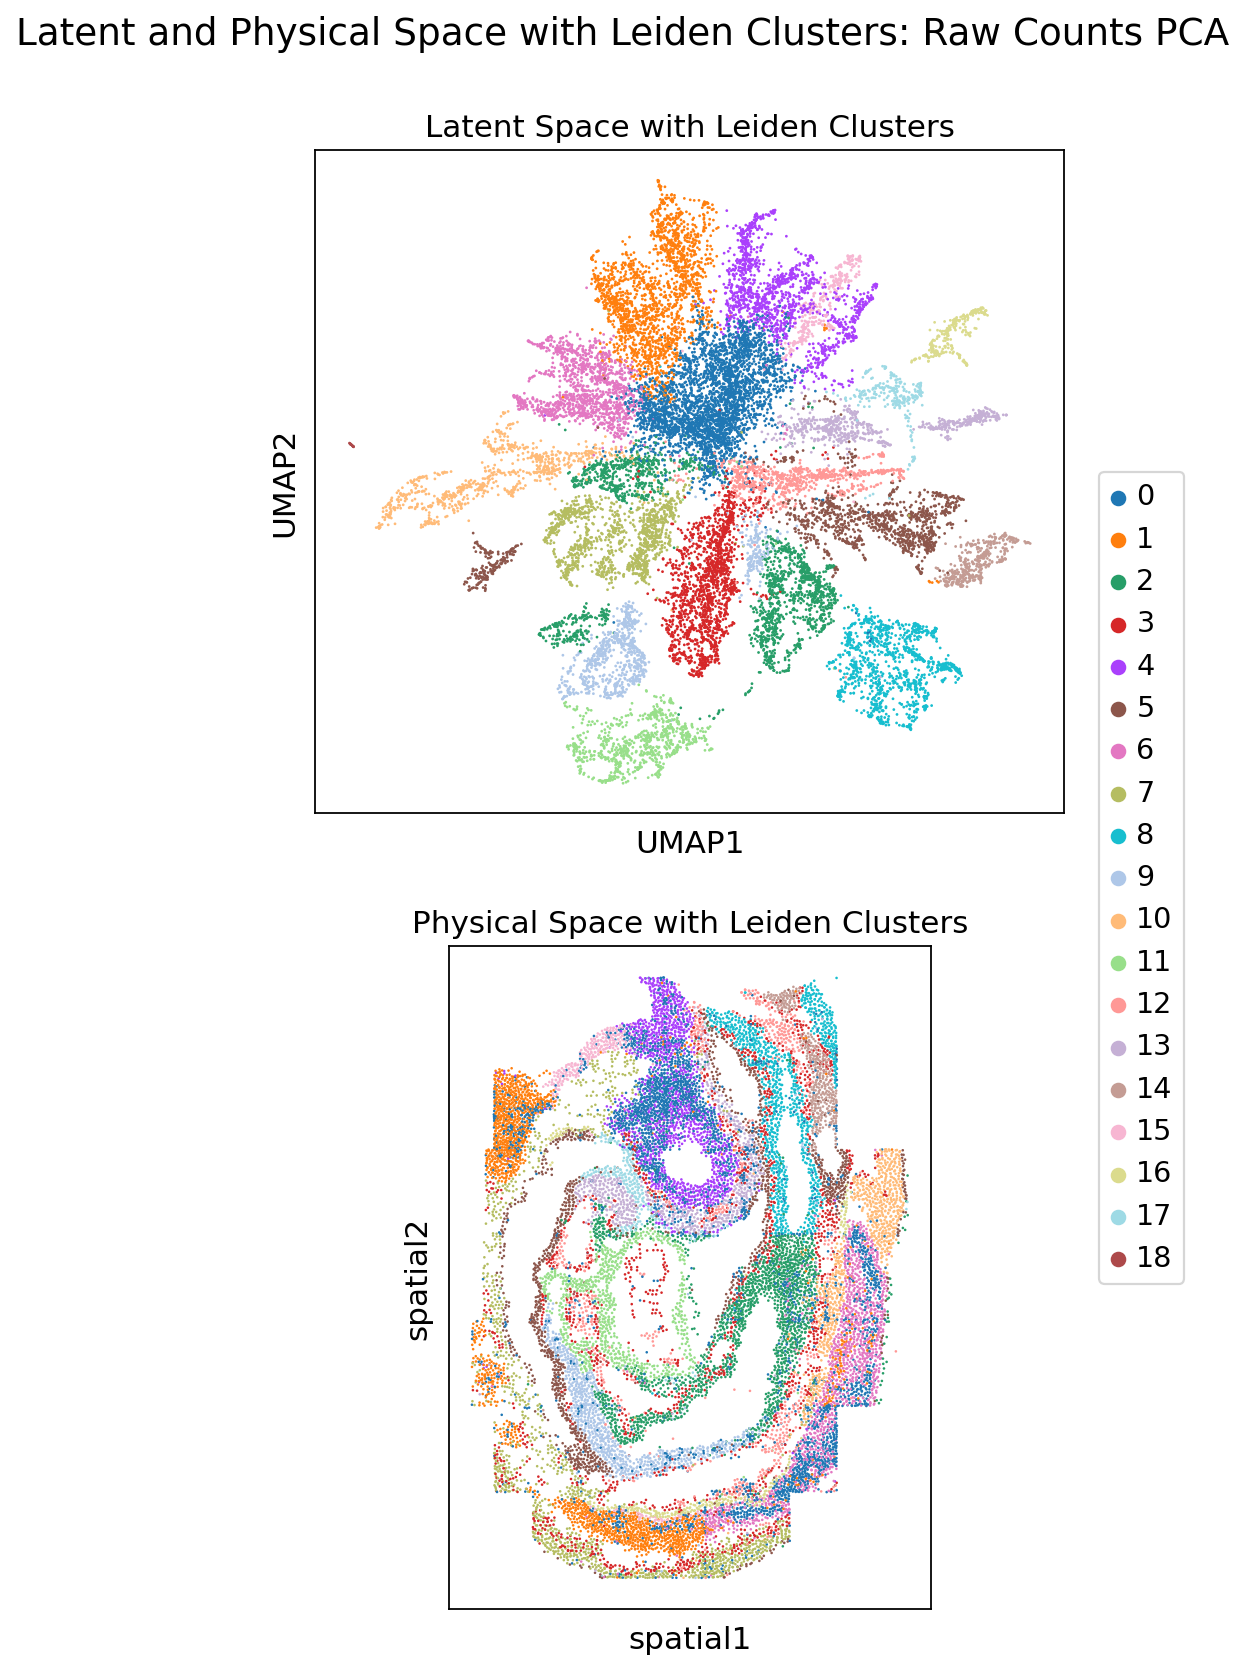

In [9]:
# Create subplot of latent Leiden cluster annotations in physical and latent space
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 12))
title = fig.suptitle(t="Latent and Physical Space with Leiden Clusters: Raw Counts PCA")
sc.pl.umap(adata=adata,
           color=[f"latent_raw_counts_pca_leiden_{str(leiden_resolution)}"],
           title=f"Latent Space with Leiden Clusters",
           ax=axs[0],
           show=False)
sc.pl.spatial(adata=adata,
              color=[f"latent_raw_counts_pca_leiden_{str(leiden_resolution)}"],
              spot_size=0.03,
              title=f"Physical Space with Leiden Clusters",
              ax=axs[1],
              show=False)

# Create and position shared legend
handles, labels = axs[0].get_legend_handles_labels()
lgd = fig.legend(handles, labels, bbox_to_anchor=(1.1, 0.75))
axs[0].get_legend().remove()
axs[1].get_legend().remove()

# Adjust, save and display plot
plt.subplots_adjust(wspace=0, hspace=0.2)
fig.savefig(f"{figure_folder_path}/latent_physical_comparison_raw_counts_pca_leiden_{current_timestamp}.png",
            bbox_extra_artists=(lgd, title),
            bbox_inches="tight")
plt.show()

## 4. scVI Model

In [10]:
scvi.model.SCVI.setup_anndata(adata,
                              layer="counts")

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [11]:
model = scvi.model.SCVI(adata)

In [12]:
model

SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal
Training status: Not Trained

In [13]:
model.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|█████████████████████████████████████████████████████████████████████████| 400/400 [04:16<00:00,  1.53it/s, loss=265, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|█████████████████████████████████████████████████████████████████████████| 400/400 [04:16<00:00,  1.56it/s, loss=265, v_num=1]


In [14]:
adata.obsm[latent_key] = model.get_latent_representation()

In [15]:
adata.layers["scvi_normalized"] = model.get_normalized_expression(library_size="latent")

/home/cartalop/anaconda3/envs/scvi/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


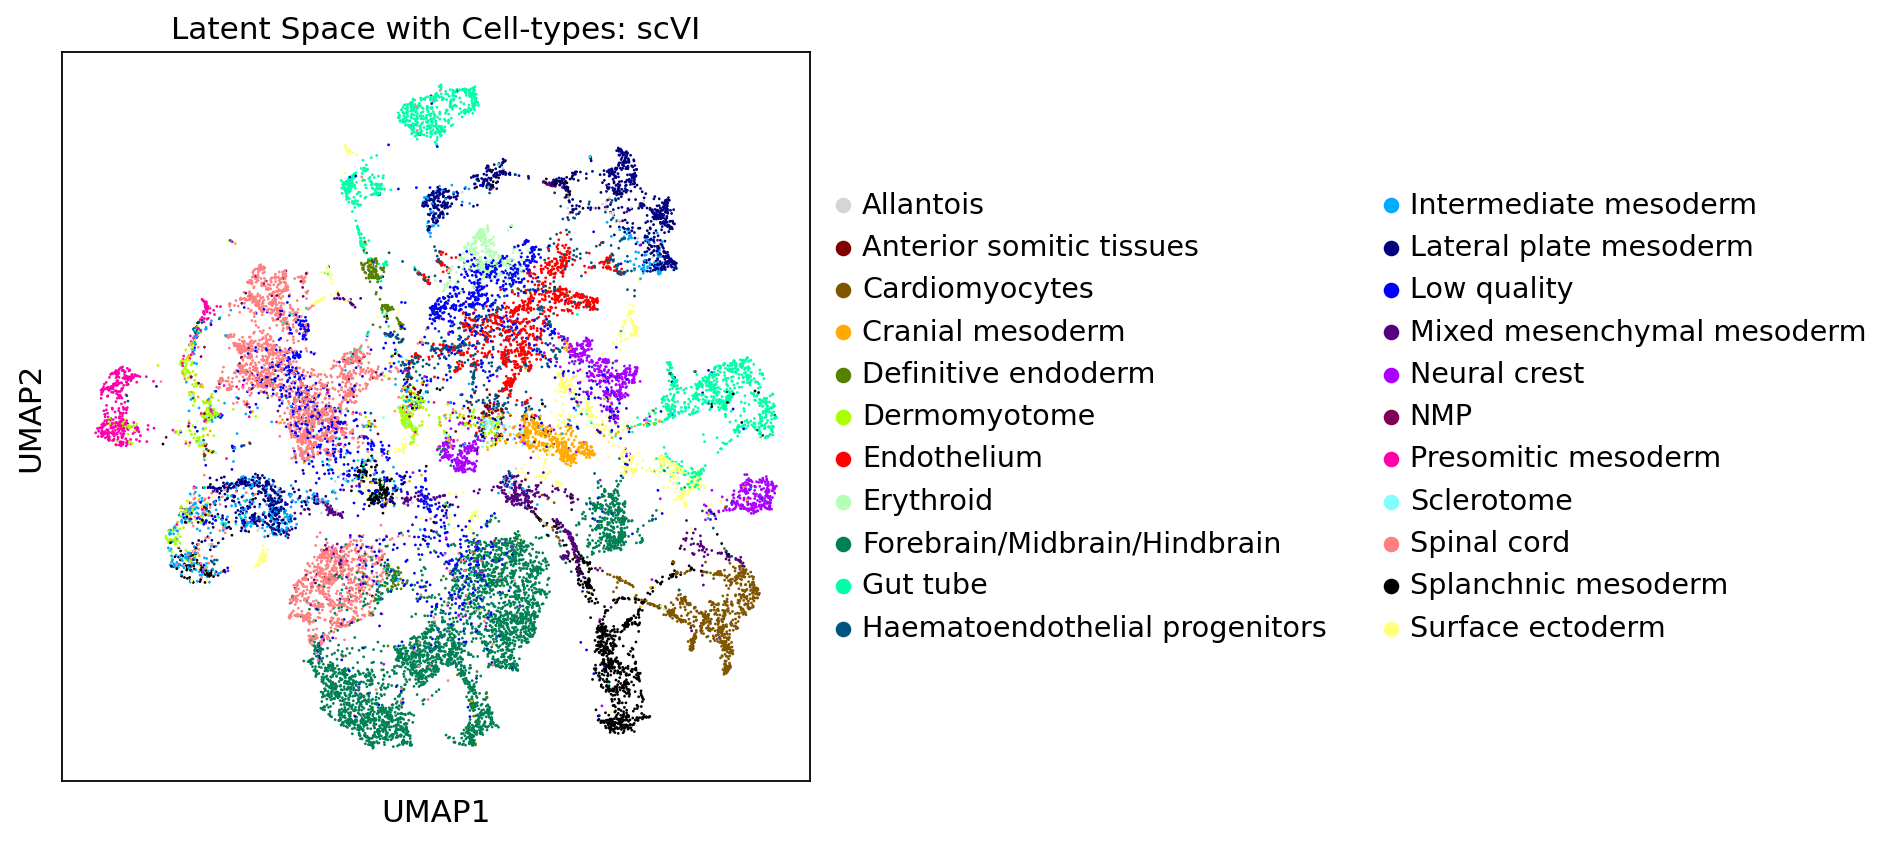

In [16]:
# Use scVI latent space for UMAP generation
sc.pp.neighbors(adata, use_rep=latent_key, n_neighbors=n_neighbors)
sc.tl.umap(adata, min_dist=0.3)

fig = sc.pl.umap(adata,
                 color=[cell_type_key],
                 title="Latent Space with Cell-types: scVI",
                 return_fig=True)
fig.savefig(f"{figure_folder_path}/latent_scvi_cell_types_{current_timestamp}.png",
            bbox_inches="tight")

In [18]:
# Compute latent Leiden clustering
sc.tl.leiden(adata=adata,
             resolution=leiden_resolution,
             random_state=random_seed,
             key_added=f"latent_scvi_leiden_{str(leiden_resolution)}")

/home/cartalop/anaconda3/envs/scvi/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


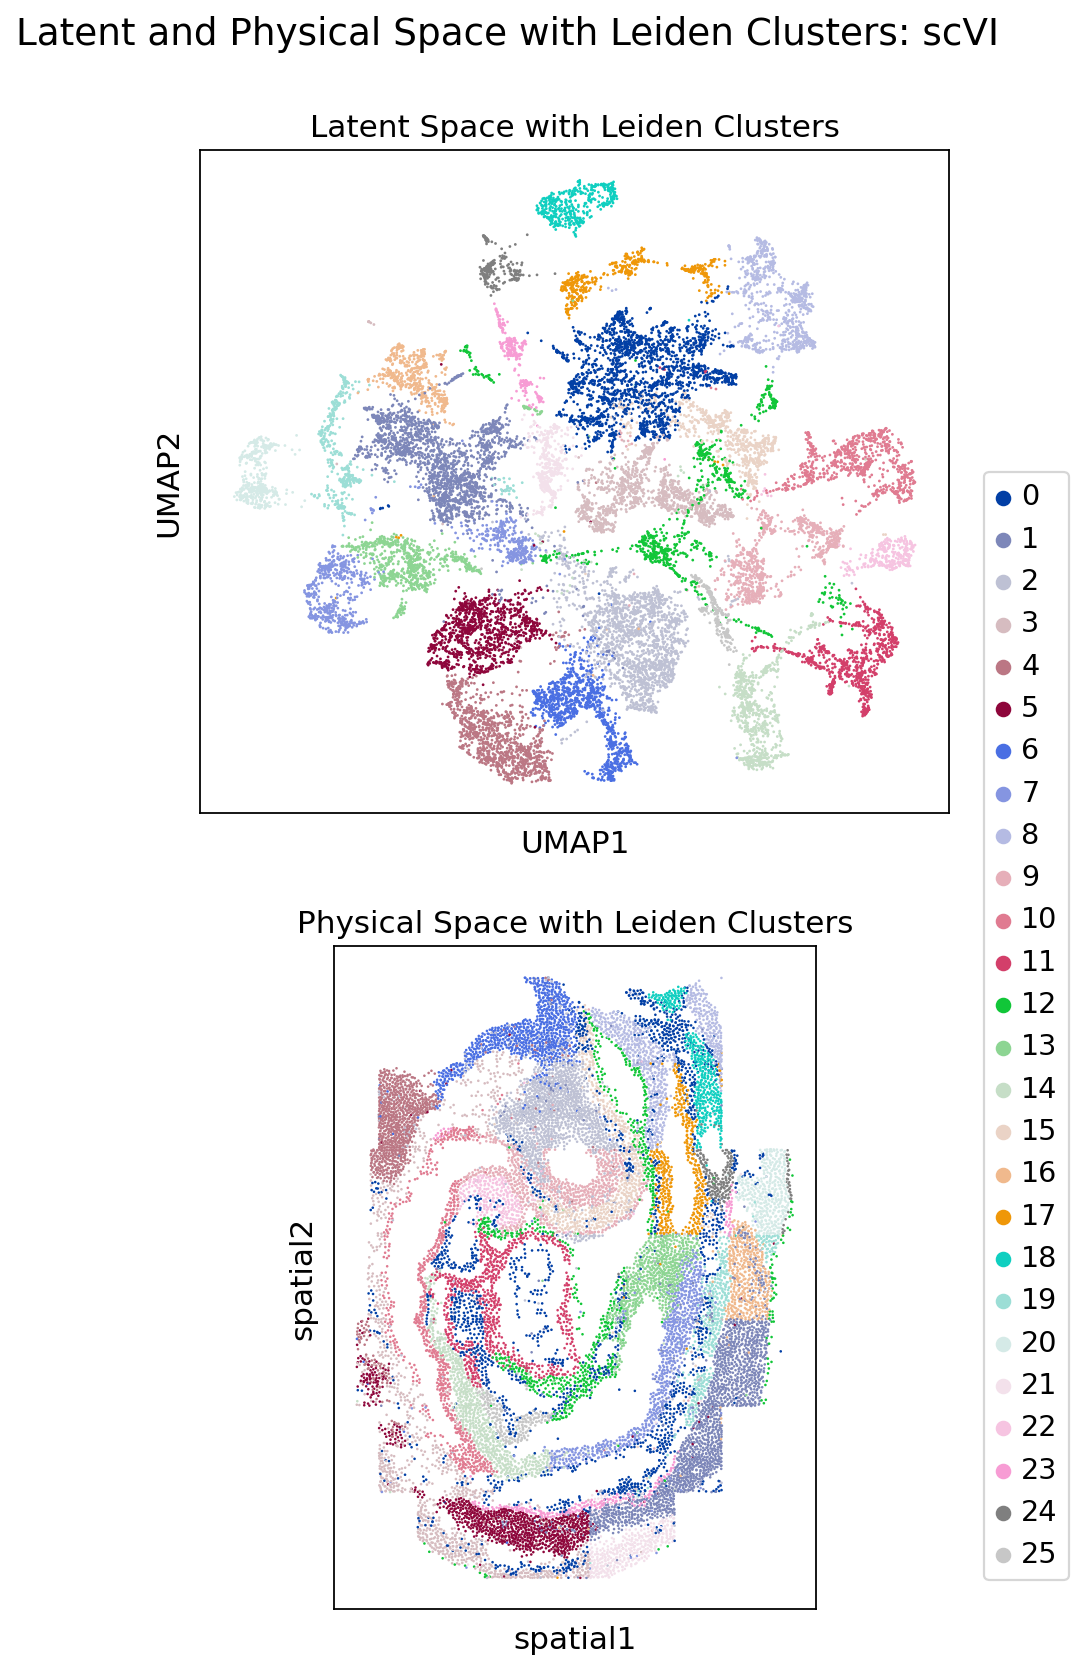

In [19]:
# Create subplot of latent Leiden cluster annotations in physical and latent space
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 12))
title = fig.suptitle(t="Latent and Physical Space with Leiden Clusters: scVI")
sc.pl.umap(adata=adata,
           color=[f"latent_scvi_leiden_{str(leiden_resolution)}"],
           title=f"Latent Space with Leiden Clusters",
           ax=axs[0],
           show=False)
sc.pl.spatial(adata=adata,
              color=[f"latent_scvi_leiden_{str(leiden_resolution)}"],
              spot_size=0.03,
              title=f"Physical Space with Leiden Clusters",
              ax=axs[1],
              show=False)

# Create and position shared legend
handles, labels = axs[0].get_legend_handles_labels()
lgd = fig.legend(handles, labels, bbox_to_anchor=(1.1, 0.75))
axs[0].get_legend().remove()
axs[1].get_legend().remove()

# Adjust, save and display plot
plt.subplots_adjust(wspace=0, hspace=0.2)
fig.savefig(f"{figure_folder_path}/latent_physical_comparison_scvi_leiden_{current_timestamp}.png",
            bbox_extra_artists=(lgd, title),
            bbox_inches="tight")
plt.show()

In [ ]:
# Store data to disk
adata.write(f"{data_folder_path}/{dataset}_scvi.h5ad")